In [1]:
from DataManager import CALFData, collateGCN
import numpy as np
import torch 
from train import trainer
import pickle
from dataclasses import dataclass
import matplotlib.pyplot as plt
from Visualiser import collateVisGCN, Visualiser
from helpers.evaluation import segmentation_correlation
from helpers.classes import EVENT_DICTIONARY_V2_ALIVE as event_enc
from helpers.classes import get_K_params
import seaborn as sns
from SpottingModel import SpottingModel

In [3]:
@dataclass
class Args:
    receptive_field = 6
    fps = 5
    chunks_per_epoch = 1824
    class_split = "alive"
    chunk_size = 30
    batch_size = 32
    input_channel = 13
    feature_multiplier=1
    backbone_player = "GCN"
    max_epochs=180
    load_weights=None
    model_name="Testing_Model"
    dim_capsule=16
    lambda_coord=5.0
    lambda_noobj=0.5
    patience=25
    LR=1e-03
    GPU=0 
    max_num_worker=1
    loglevel='INFO'
    annotation_nr = 10
    K_parameters = get_K_params(chunk_size)
    focused_annotation = None
    generate_augmented_data = True
    sgementation_path = "models/detector_probs.pth.tar"
    freeze_model = True

In [3]:
args = Args
collate_fn = collateGCN

validation_dataset = CALFData(split="validate", args=args)
validate_loader = torch.utils.data.DataLoader(validation_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

Data preprocessing:   0%|          | 0/1 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [109]:
from helpers.preprocessing import animate_clip
label, target, representation = next(iter(validation_dataset))
coords_arr = np.array([rep.x for rep in representation]).transpose((0,2,1))[15:-15]
target.shape[0]
annotation = "Pass"

animate_clip(coords_arr, target, annotation)

In [3]:
args = Args
collate_fn = collateGCN

train_dataset = CALFData(split="train", args=args)
validation_dataset = CALFData(split="validate", args=args)

train_loader = torch.utils.data.DataLoader(train_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

validate_loader = torch.utils.data.DataLoader(validation_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

model = SpottingModel(args=args)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.LR, 
                            betas=(0.9, 0.999), eps=1e-07, 
                            weight_decay=0, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True, patience=args.patience)

losses = trainer(train_loader, validate_loader,
                    model, optimizer, scheduler, 
                    criterion=criterion,
                    model_name=args.model_name,
                    max_epochs=args.max_epochs,
                    save_dir=f"models/spotting.pth.tar",
                    train_seg=False)

with open(f'results/spotting.pkl', 'wb') as file:
    pickle.dump(losses, file)

Data preprocessing:   0%|          | 0/10 [00:04<?, ?it/s]


KeyboardInterrupt: 

(<Figure size 2000x2500 with 10 Axes>,
 array([[<Axes: title={'center': 'Spotting Pressure'}>,
         <Axes: title={'center': 'Spotting Foul Committed'}>],
        [<Axes: title={'center': 'Spotting Ball Recovery'}>,
         <Axes: title={'center': 'Spotting Duel'}>],
        [<Axes: title={'center': 'Spotting Shot'}>,
         <Axes: title={'center': 'Spotting Dribble'}>],
        [<Axes: title={'center': 'Spotting Clearance'}>,
         <Axes: title={'center': 'Spotting Goal Keeper'}>],
        [<Axes: title={'center': 'Spotting Pass'}>,
         <Axes: title={'center': 'Spotting Dead'}>]], dtype=object))

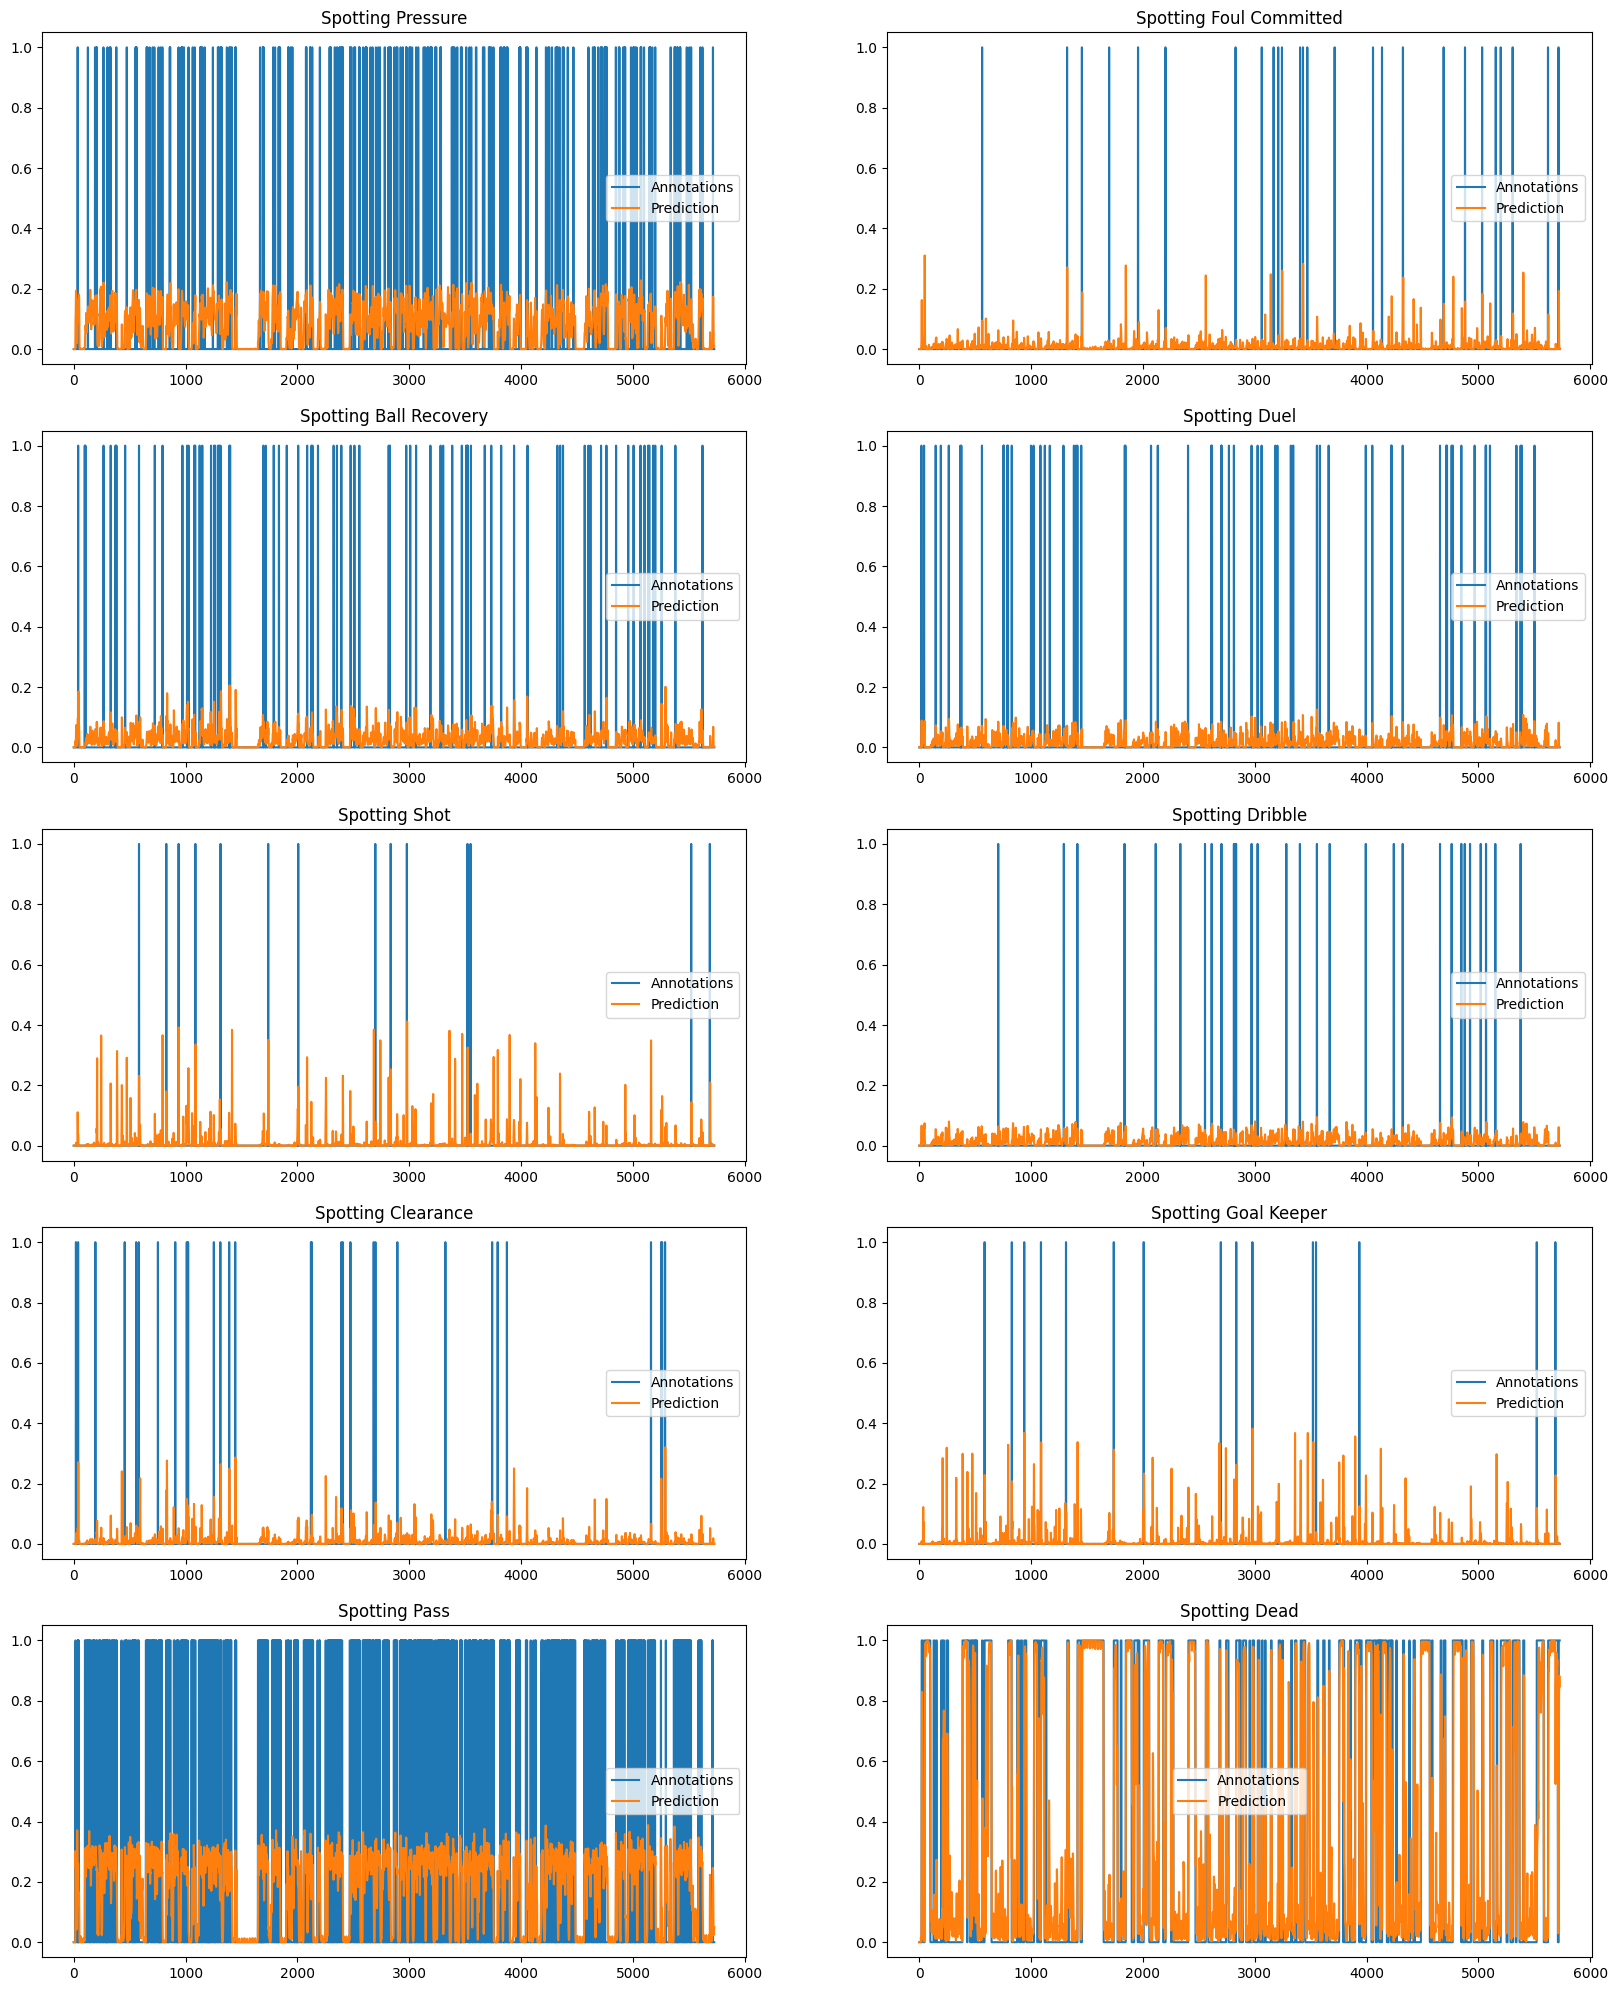

In [9]:
args = Args
collate_fn = collateVisGCN
model_path = "models/spotting.pth.tar"
model = torch.load(model_path)
visualiser = Visualiser(collate_fn, args, model, smooth_rate=None, val=True, seg_model=False)
visualiser.plot_predictions(frame_threshold=5727, save_dir="plots/PredictionsPlot.png", annotation=None)

In [17]:
class ContextAwareLoss(torch.nn.Module):

    def __init__(self, K, hit_radius = 0.1, miss_radius = 0.9):

        super(ContextAwareLoss,self).__init__()

        self.K = K
        self.hit_radius = float(hit_radius)
        self.miss_radius = float(miss_radius)

    def forward(self, gt_label, pred_score, device):
        params = self.K.to(device)
        hit_radius = self.hit_radius
        miss_radius = self.miss_radius
        y_true = gt_label
        y_pred = pred_score
        loss_before_sum = -torch.min(0.*y_true,torch.sign(y_true))*torch.max(0.*y_pred,-torch.log(y_pred+(1.-y_pred)*(torch.min(torch.max(y_true,params[0,:]),params[1,:])-params[0,:])/(params[1,:]-params[0,:]))+torch.log(torch.tensor(miss_radius).to(device)))+(1.-torch.max(0.*y_true,torch.sign(-y_true)))*torch.max(0.*y_pred,torch.max(-torch.log(1.-y_pred+torch.abs(y_true)/params[2,:])+torch.log(1.-torch.tensor(hit_radius).to(device)),-torch.log(y_pred+(torch.min(y_true,params[3,:])-params[3,:])/(params[2,:]-params[3,:]))+torch.log(torch.tensor(miss_radius).to(device))))
        loss = torch.sum(loss_before_sum)
        return loss, loss_before_sum

In [18]:
@dataclass
class Args:
    receptive_field = 6
    fps = 5
    chunks_per_epoch = 1824
    class_split = "alive"
    chunk_size = 30
    batch_size = 32
    input_channel = 13
    feature_multiplier=1
    backbone_player = "GCN"
    max_epochs=180
    load_weights=None
    model_name="Testing_Model"
    dim_capsule=16
    lambda_coord=5.0
    lambda_noobj=0.5
    patience=25
    LR=1e-03
    GPU=0 
    max_num_worker=1
    loglevel='INFO'
    annotation_nr = 10
    K_parameters = get_K_params(chunk_size)
    focused_annotation = None
    generate_augmented_data = False
    sgementation_path = "models/detector_probs.pth.tar"
    freeze_model = True


args = Args
collate_fn = collateGCN

validation_dataset = CALFData(split="validate", args=args)

validate_loader = torch.utils.data.DataLoader(validation_dataset,
            batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)

model = torch.load("models/detector_probs.pth.tar")

labels, target, representation = next(iter(validate_loader))
output_segmentation = model(representation)
device = torch.device("cpu")
criterion = ContextAwareLoss(K=validation_dataset.K_parameters)

In [19]:

loss_segmentation, loss_before_sum = criterion(labels, output_segmentation, device) 

In [23]:
weights = torch.tensor([1,2,1,2,1,2,1,2,1,2])

In [24]:
weighted_loss = loss_before_sum * weights
weighted_loss.shape

torch.Size([32, 150, 10])

In [26]:
print(weighted_loss[0,100,1])
print(loss_before_sum[0,100,1])

tensor(0.3520, dtype=torch.float64, grad_fn=<SelectBackward0>)
tensor(0.1760, dtype=torch.float64, grad_fn=<SelectBackward0>)
